In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

In [2]:
class ProcessingData:
    
    def __init__(self,filepath):
        with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            self.data = u.load()

    def fix_data(self, interval):
        """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
        converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
        don't have dt equal to interval.
        :param data:
        :param interval: float:minutes"""
        def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

        def h(x):
            if x == 1:
                return 1
            else:
                return 0

        def c(x):
            if x == 2:
                return 1
            else:
                return 0

        self.data["action"] = self.data["action"].map(f)
        self.data['action_heating'] = self.data["action"].map(h)
        self.data['action_cooling'] = self.data['action'].map(c)

        #print self.data.head()

        return self.data, self.data[self.data["dt"] == interval]
    
    def filter_data(self):
        self.data = self.data.drop(['t_next', 'dt', 'action', 'previous_action', 'action_duration', \
                                    'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        return self.data
    
    def drop_nan(self):
        self.data = self.data.dropna()
        return self.data


In [3]:
training = ProcessingData("../Data/avenal-animal-shelter_training_data.pkl")
training_data = training.fix_data(5)
training_data = training.filter_data()
training_data = training.drop_nan()

In [4]:
testing = ProcessingData("../Data/avenal-animal-shelter_test_data.pkl")
testing_data = testing.fix_data(5)
testing_data = testing.filter_data()
testing_data = testing.drop_nan()

In [5]:
def scaling(data):
    scaled = np.empty([data.shape[0], data.shape[1]])
    numSamples = data.shape[0]
    numFeatures = data.shape[1]
    dataValues = data.values
    dataValues = dataValues.astype('float32')
    for i in range(numFeatures):
        maxNum = max(dataValues[:,i])
        for j in range(numSamples):
            scaled[j,i] = dataValues[j,i]/maxNum
    return scaled

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
train_scaled = scaling(training_data)
print(train_scaled)
train_reframed = series_to_supervised(train_scaled, 2, 1)
train_reframed.drop(train_reframed.columns[-4:], axis=1, inplace=True)
train_reframed.head()

[[ 0.85676116  0.63942021  0.          0.          0.        ]
 [ 0.85696673  0.63942021  0.          0.          0.        ]
 [ 0.85696673  0.63962066  0.          0.          0.        ]
 ..., 
 [ 0.85080147  0.74038088  0.          0.          0.        ]
 [ 0.85573369  0.74038088  0.          0.          0.        ]
 [ 0.85819978  0.74038088  0.          0.          0.        ]]


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
2,0.856761,0.639420,0.0,0.0,0.0,0.856967,0.639420,0.0,0.0,0.0,0.856967
3,0.856967,0.639420,0.0,0.0,0.0,0.856967,0.639621,0.0,0.0,0.0,0.856967
4,0.856967,0.639621,0.0,0.0,0.0,0.856967,0.640222,0.0,0.0,0.0,0.855734
5,0.856967,0.640222,0.0,0.0,0.0,0.855734,0.641024,0.0,0.0,0.0,0.856967
6,0.855734,0.641024,0.0,0.0,0.0,0.856967,0.641625,0.0,0.0,0.0,0.855734


In [8]:
test_scaled = scaling(testing_data)
test_reframed = series_to_supervised(test_scaled, 2, 1)
test_reframed.drop(test_reframed.columns[-4:], axis=1, inplace=True)
test_reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
2,0.941785,0.747789,0.0,0.0,0.0,0.941785,0.748107,0.0,0.0,0.0,0.944373
3,0.941785,0.748107,0.0,0.0,0.0,0.944373,0.748422,0.0,0.0,0.0,0.944373
4,0.944373,0.748422,0.0,0.0,0.0,0.944373,0.748731,0.0,0.0,0.0,0.944373
5,0.944373,0.748731,0.0,0.0,0.0,0.944373,0.749038,0.0,0.0,0.0,0.944373
6,0.944373,0.749038,0.0,0.0,0.0,0.944373,0.748744,0.0,0.0,0.0,0.944373


In [18]:
# split into input and outputs
train = train_reframed.values
test = test_reframed.values
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 2, 5))
test_X = test_X.reshape((test_X.shape[0], 2, 5))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(53184, 2, 5) (53184,) (13388, 2, 5) (13388,)


In [19]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [40]:
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 53184 samples, validate on 13388 samples
Epoch 1/50
 - 5s - loss: 0.1069 - acc: 3.3845e-04 - val_loss: 0.0318 - val_acc: 7.4694e-04
Epoch 2/50
 - 3s - loss: 0.0177 - acc: 3.3845e-04 - val_loss: 0.0367 - val_acc: 7.4694e-04
Epoch 3/50
 - 3s - loss: 0.0169 - acc: 3.3845e-04 - val_loss: 0.0367 - val_acc: 7.4694e-04
Epoch 4/50
 - 3s - loss: 0.0165 - acc: 3.3845e-04 - val_loss: 0.0367 - val_acc: 7.4694e-04
Epoch 5/50
 - 2s - loss: 0.0160 - acc: 3.3845e-04 - val_loss: 0.0357 - val_acc: 7.4694e-04
Epoch 6/50
 - 2s - loss: 0.0158 - acc: 3.3845e-04 - val_loss: 0.0355 - val_acc: 7.4694e-04
Epoch 7/50
 - 2s - loss: 0.0156 - acc: 3.3845e-04 - val_loss: 0.0357 - val_acc: 7.4694e-04
Epoch 8/50
 - 2s - loss: 0.0153 - acc: 3.3845e-04 - val_loss: 0.0345 - val_acc: 7.4694e-04
Epoch 9/50
 - 2s - loss: 0.0151 - acc: 3.3845e-04 - val_loss: 0.0347 - val_acc: 7.4694e-04
Epoch 10/50
 - 2s - loss: 0.0149 - acc: 3.3845e-04 - val_loss: 0.0334 - val_acc: 7.4694e-04
Epoch 11/50
 - 2s - loss: 0.0147 - acc:

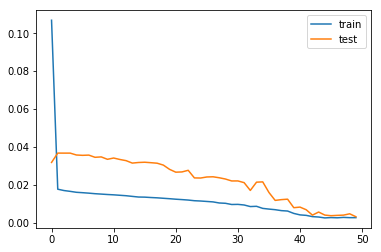

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
yhat = model.predict(test_X)
yhat

array([[ 0.93884981],
       [ 0.94013101],
       [ 0.94124991],
       ..., 
       [ 0.93499261],
       [ 0.93499386],
       [ 0.93562043]], dtype=float32)

In [43]:
maxT_in = max(testing_data['t_in'])
maxT_in

77.299999999999997

In [44]:
inv_yhat = np.array([])
for y in yhat:
    inv_yhat = np.append(inv_yhat, y*maxT_in)
inv_yhat

array([ 72.5730896 ,  72.67212677,  72.75862122, ...,  72.27493286,
        72.27503204,  72.32346344])

In [45]:
inv_y = np.array([])
for y in test_y:
    inv_y = np.append(inv_y, y*maxT_in)
inv_y

array([ 72.99999694,  72.99999694,  72.99999694, ...,  72.29999794,
        72.39999779,  72.49999765])

In [46]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.770
